# **Movie Recommendation System**

# 1. **OBJECTIVE**

Recommender systems are essential for websites or online stores with millions of items, helping users find what they're looking for by narrowing down their choices. These systems are widely used by companies like Netflix and Amazon to suggest content tailored to individual users.

Our goal is to build a Collaborative Filtering-based Movie Recommendation System. The system will predict how a user would rate a movie they haven’t watched yet, and we aim to minimize the difference between predicted and actual ratings using metrics like RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error).

# **2. DATA COLLECTION**

In [ ]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

!pip install fuzzywuzzy
!pip install scikit-surprise

from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357285 sha256=2d34a9ea3b22c6dba1aaf631c0c9104f02f40cb76848e51bf65c0e062b852dfc
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


# **3. DATA PREPARATION/PREPROCESSING**

In [ ]:
# Loading the dataset
movie_ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# Creating a newId for every movie to reduce the range of existing movieId
movies["newId"] = range(1, movies["movieId"].nunique()+1)

# Converting the the UTC timestamp to Datetime
movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(
    lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d") if pd.notnull(x) else x
)

# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

# Dropping the newId from the datasets
movie_ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

# Checking the features and no. of records in the dataset
print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()



The number of records are :  18941894
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,99851,45,4.0,1996-01-29,To Die For (1995),Comedy|Drama|Thriller
2,85252,34,5.0,1996-01-29,Babe (1995),Children|Drama
3,85252,32,4.0,1996-01-29,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
4,85252,24,3.0,1996-01-29,Powder (1995),Drama|Sci-Fi


**3.1 DATA CLEANING**

First, we’ll clean the data by addressing missing values, handling outliers and rare values, and removing any features that aren’t useful.

In [ ]:
# Checking for duplicates
print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

# Checking the columns' titles and datatypes
movie_ratings.info()

# Checking the number of missing values in data
movie_ratings.isna().sum()


No. of duplicates records in the dataset :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18941894 entries, 0 to 18941893
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 867.1+ MB


,0
userId,0
movieId,0
rating,0
date,0
title,0
genres,0


Observations:

The dataset appears to be well maintained as we do not see any duplicate records or missing values.

**3.2 EXPLORATORY DATA ANALYSIS**

Now that data cleaning is complete, we can proceed with EDA to identify patterns and relationships that will give us deeper insights into the dataset.

The count of unique userID in the dataset is :  131089
The count of unique movieID in the dataset is :  26255


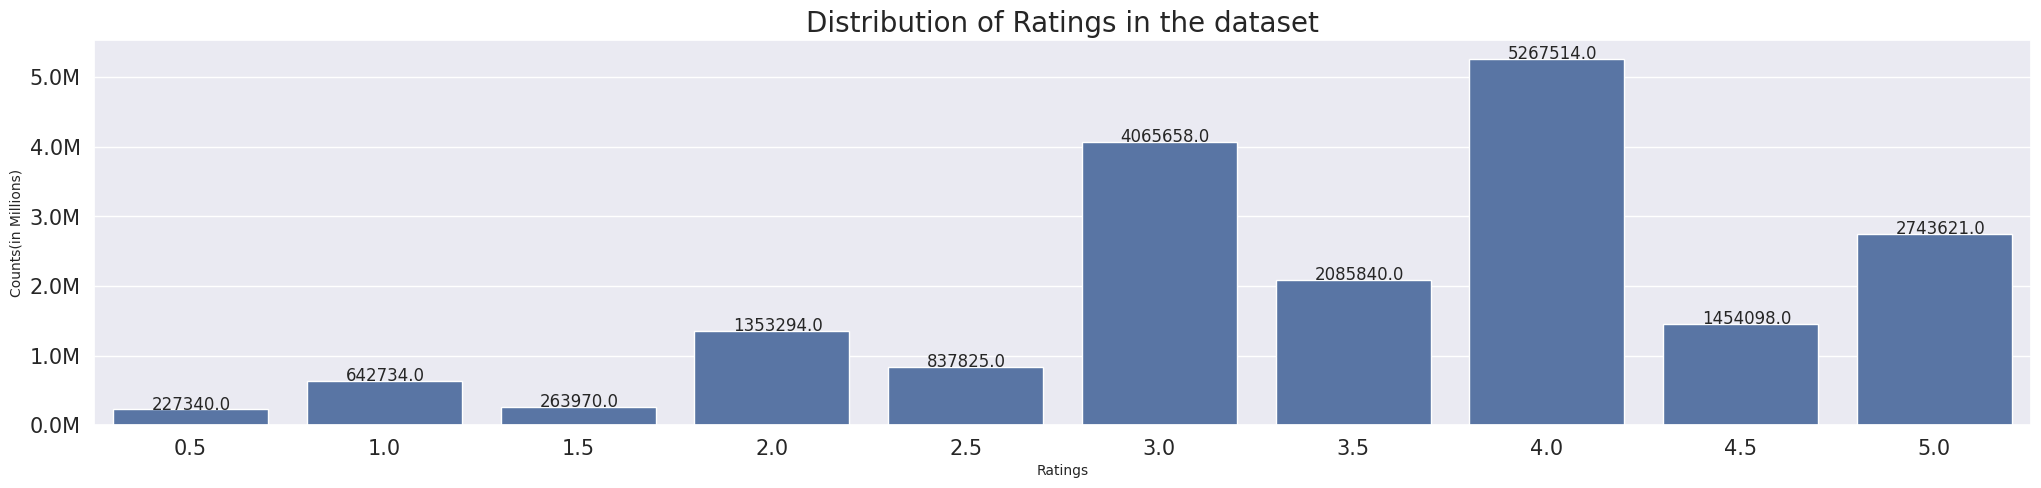

The count of unique title in the dataset is :  26240
Genres Extracted from the dataset.


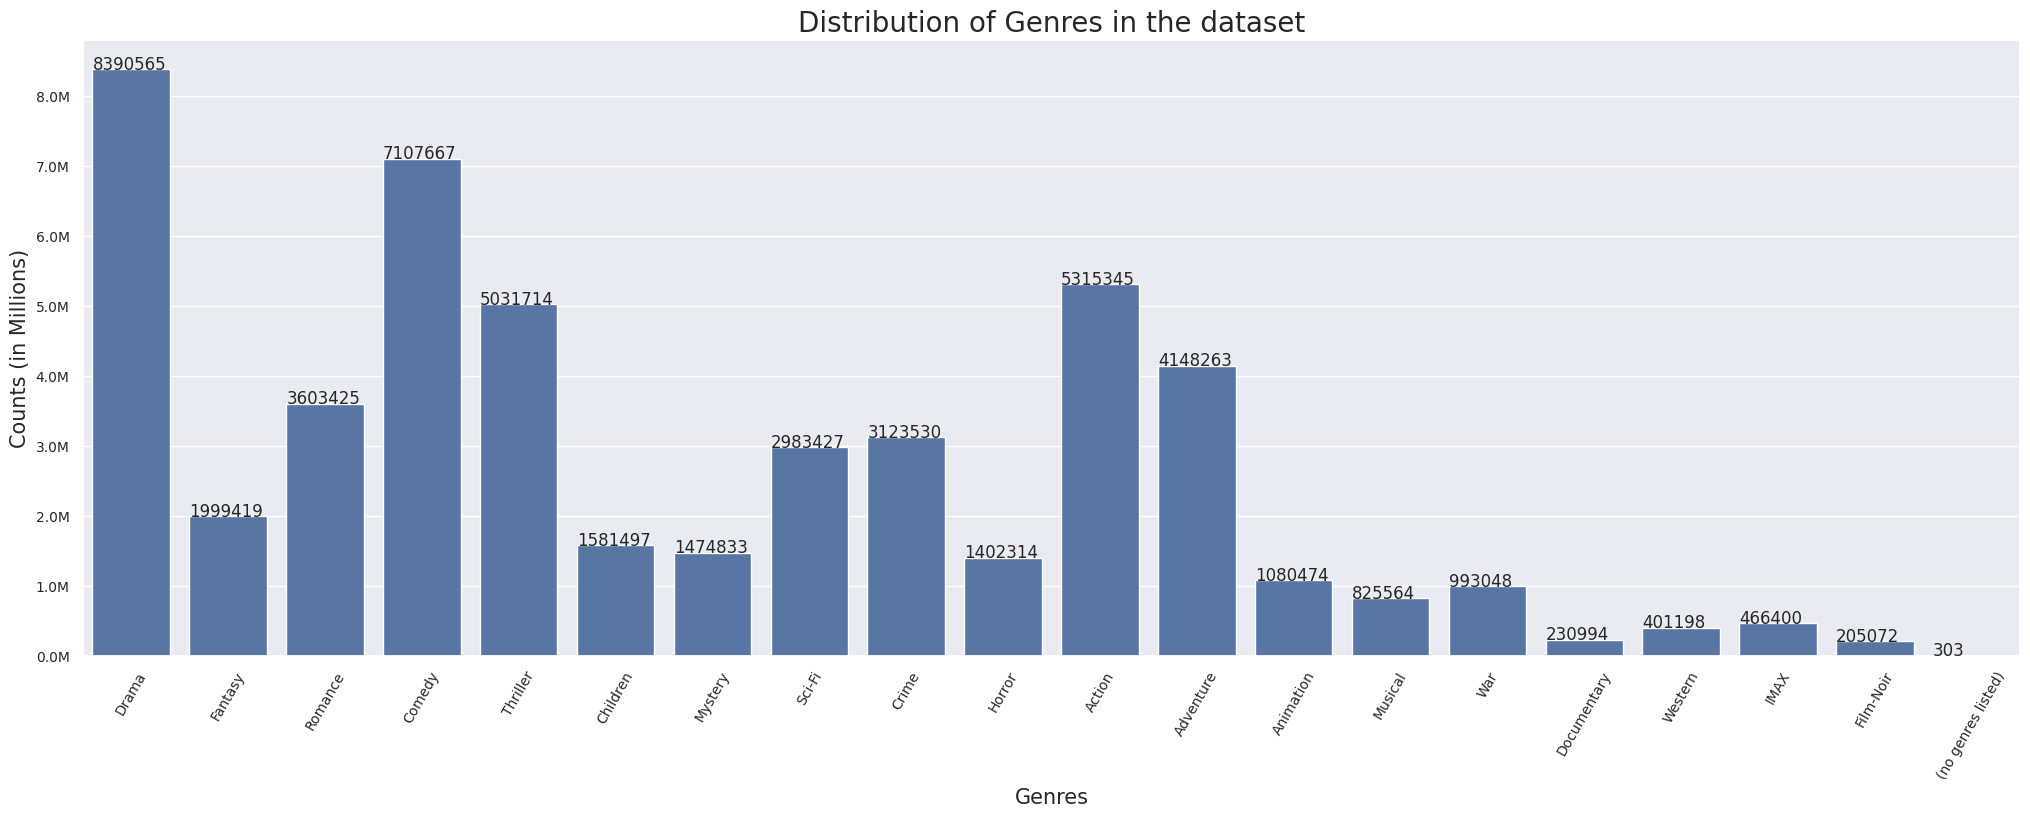

In [ ]:
# Checking the feature "userID"
total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)

# Checking the feature "movieID"
total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)

# Helper function to Change the numeric label in terms of Millions
def changingLabels(number):
    return str(number/10**6) + "M"


# Checking the feature "rating"
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=movie_ratings, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

# Checking the feature "title"
movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())

# Extract unique Genres along with their count
unique_genres = {}

def ExtractGenres(x):
    # Check if x is a string before attempting to split
    if isinstance(x, str):
        for g in x.split("|"):
            if g not in unique_genres.keys():
                unique_genres[g] = 1
            else:
                unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")

# Visualizing the feature "Genres"
genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"]

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()


Observations:

Graph-1:

The ratings given by users to movies lies in between 0.5 to 5.
A high proportion of the movies have been rated 3, 3.5 or 4 by the users.
The distribution of ratings look a bit left skewed as large proportion of ratings is in between 3 to 5.

Graph-2:

There are 19 different genres of movies while there are few whose genre has not been mentioned.
Drama, Comedy, Action and Thriller are top 4 genres of movies present in the dataset.

**3.2.2 TRAIN AND TEST SPLITTING**

Here we split the data into train and test sets.

In [ ]:
import os
import pandas as pd

# Set the file path to the local temporary directory in Colab
file_path = "/content/temp_data"

# Create the directory if it doesn't exist
os.makedirs(file_path, exist_ok=True)

# Train Data
if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it locally..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Train Data from local storage..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)

# Test Data
if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it locally..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Test Data from local storage..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)

# Creating list of unique movies from Train Set
print("List of unique movies from Train Set: ")

movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

Creating Train Data and saving it locally..
Creating Test Data and saving it locally..


,movieId,title,genres
0,1154.0,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,32.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
2,39.0,Clueless (1995),Comedy|Romance
3,6.0,Heat (1995),Action|Crime|Thriller
4,10.0,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  15153515
Number of unique users in train data :  106442
Number of unique movies in train data :  12359


Analysing the number of ratings with date

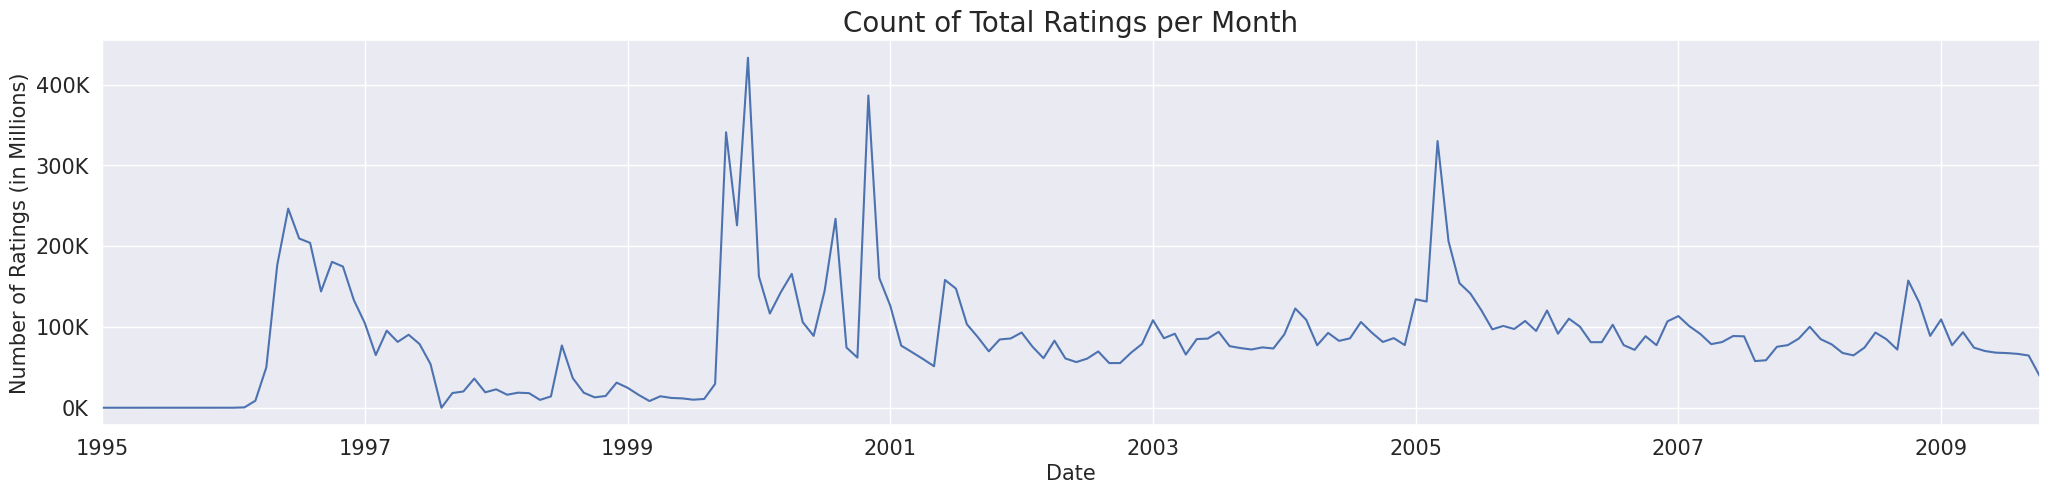

In [ ]:
# Extracting the day of week from the date when rating was provided
Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek > 5 else 0)

# Converting the number into 'Ks.
def ChangingLabelsInK(number):
    return str(int(number/10**3)) + "K"

# Visualizing the count of total ratings made per month
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

Observations:

The no. of ratings per month was very high in few of the months between 1996 to 1998.
Similarly, post the 2000s, there are few months with very high number of ratings.
The count remains steady after 2001 till 2010, with a spike at few months of 2006.

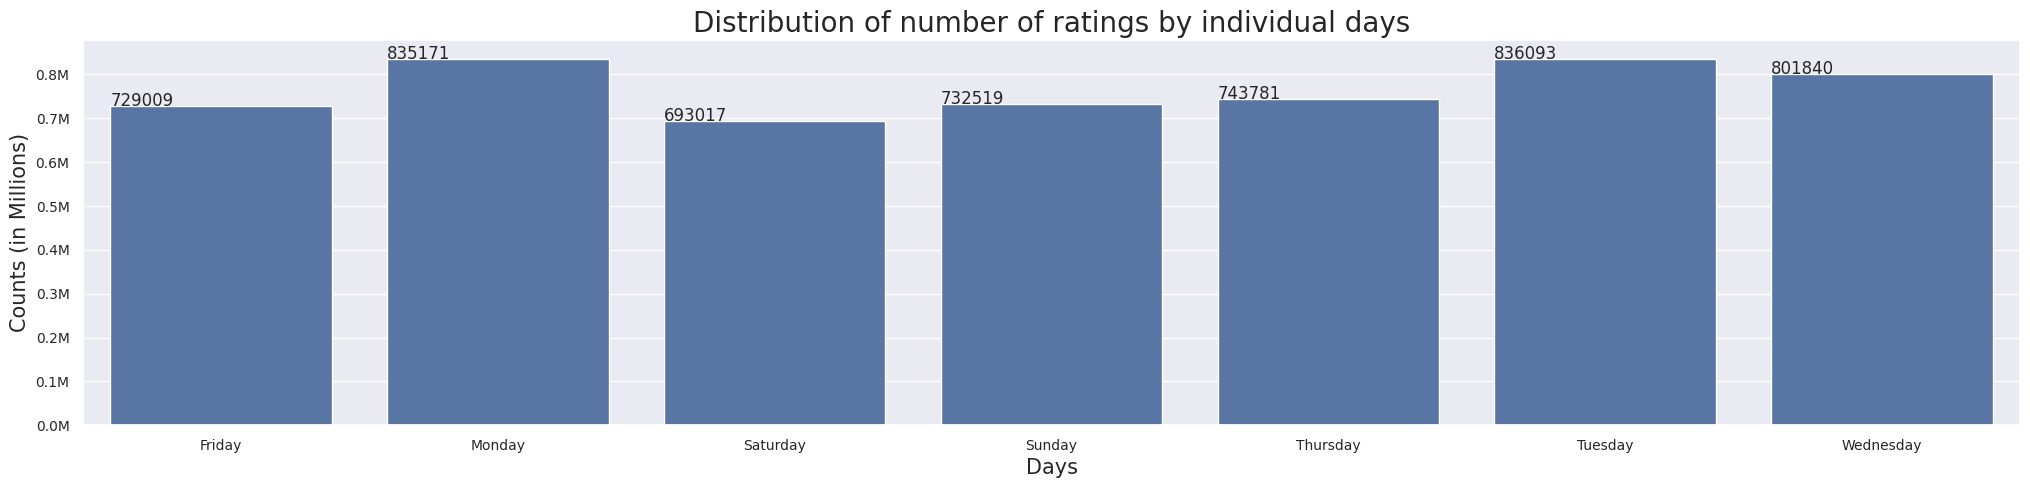

In [ ]:
# Visualizing the count of ratings by individual days of the week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="DayOfWeek", y="rating" , data=Train_Data.groupby(by=["DayOfWeek"], as_index=False)["rating"].count(), ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by individual days", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Observations:

1. The no. of ratings does not vary too much in the days of the week.
2. "Monday" and "Tuesday" have more no. of ratings than any other days.
3. The number of ratings during weekends is clearly lesser than weekdays.

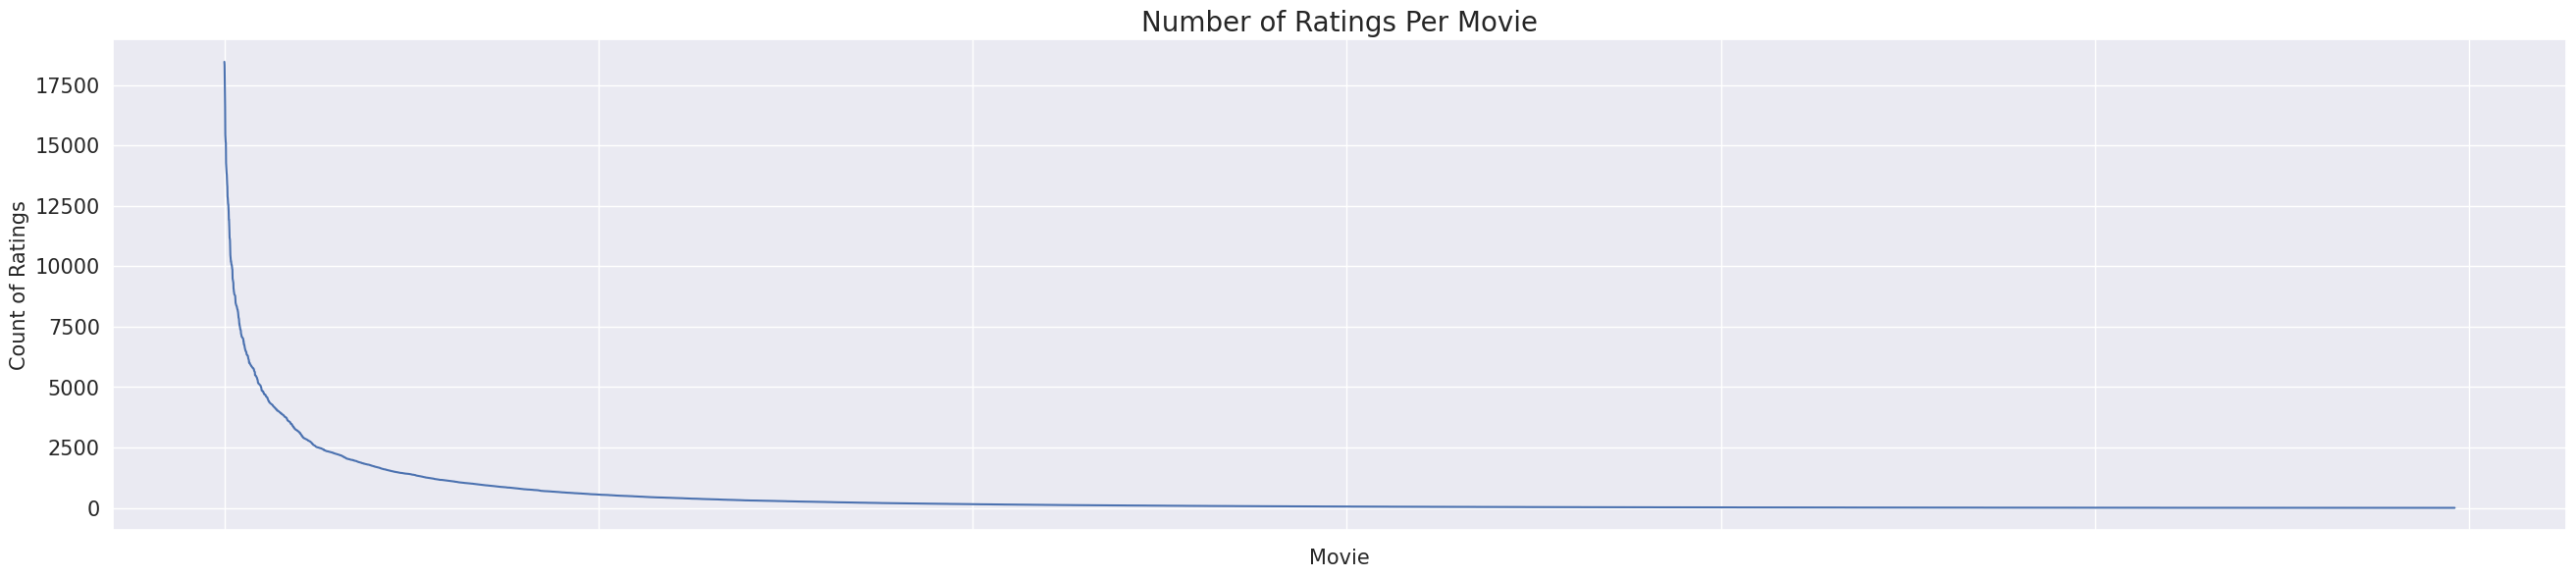

In [ ]:
# Calculating count of ratings received for movies
no_of_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].count().sort_values(by=["rating"], ascending = False)
no_of_ratings_per_movie = no_of_ratings_per_movie.reset_index(drop=True)

# Visualizing the number of ratings for the movies
sns.set(style="darkgrid")

fig = plt.figure(figsize = (25, 5))
axes = fig.add_axes([0.1, 0.1, 1, 1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.ylabel("Count of Ratings", fontsize = 15)

plt.plot(no_of_ratings_per_movie["rating"].values)

plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

Observations:

It is quite clear that there are some movies which are very popular and were rated by many users as compared to other movies, which has caused the plot to be skewed.

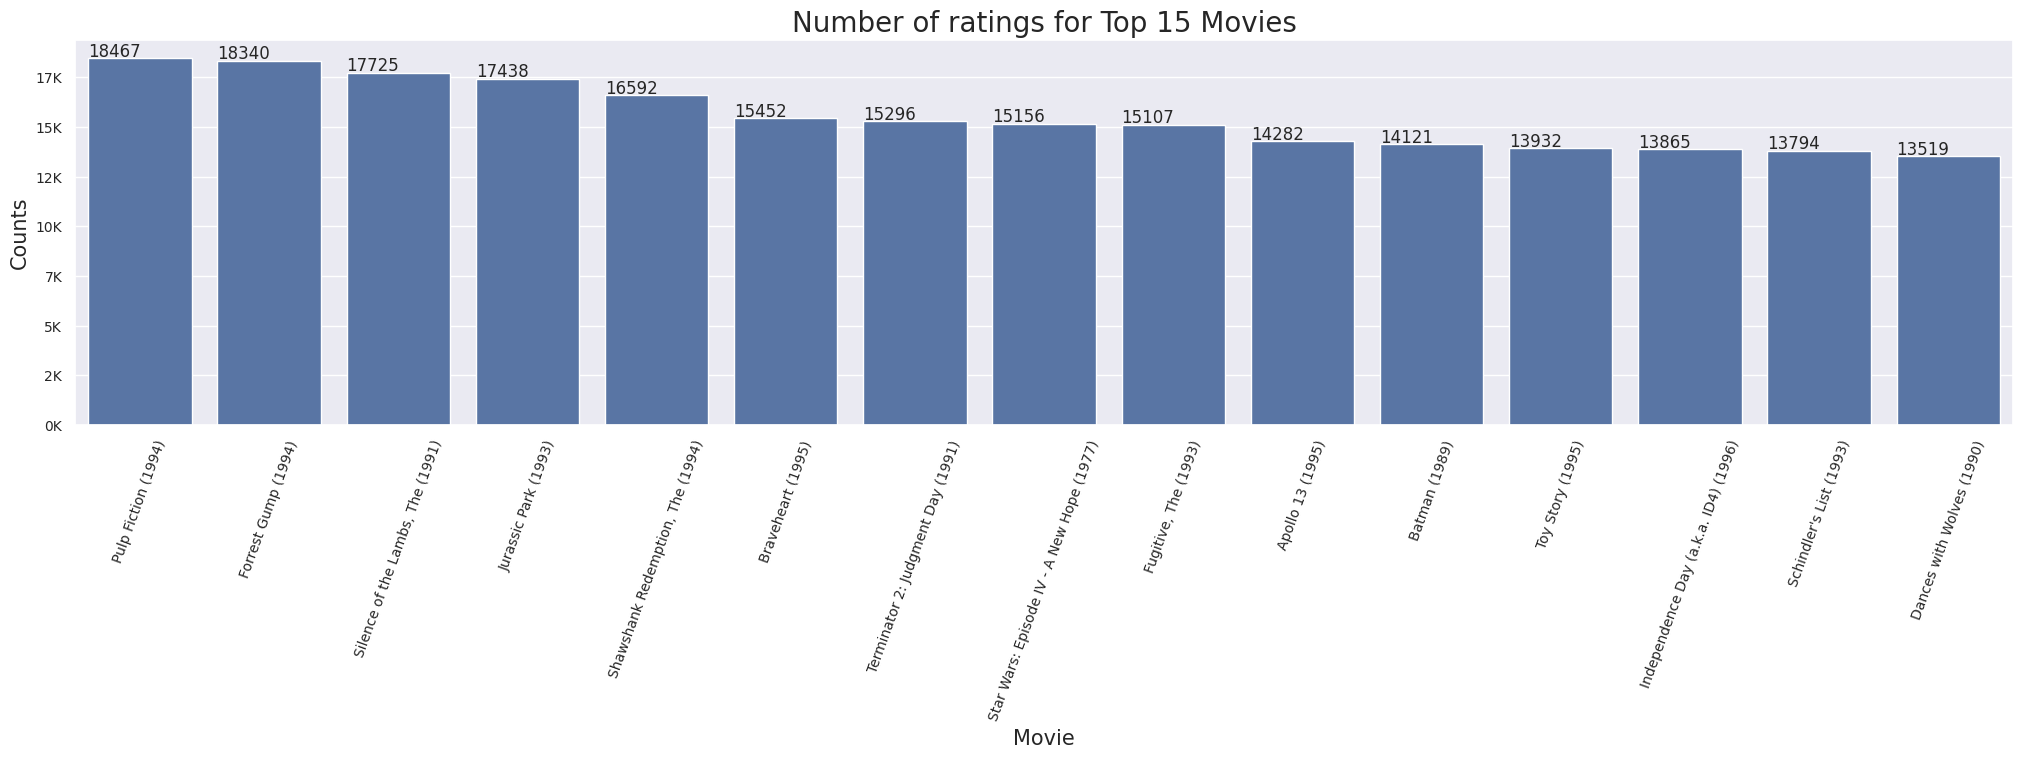

In [ ]:
# Visualizing top 15 movies heavily rated movies.
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="rating", data=no_of_ratings_per_movie[:15], ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Movies", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

**3.3 FEATURE ENGINEERING**

We will now prepare the data for the ML algorithms.

We will be creating matrices like: User-Item matrix, User-User and Item-Item similarity matrix.

In [ ]:
import os
import pandas as pd

# Set the file path to the local temporary directory in Colab
file_path = "/content/temp_data"

# Create the directory if it doesn't exist
os.makedirs(file_path, exist_ok=True)

# Train Data
if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it locally..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Train Data from local storage..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)

# Test Data
if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it locally..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Test Data from local storage..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)

Creating Train Data and saving it locally..
Creating Test Data and saving it locally..


In [ ]:
# Creating/loading user-movie sparse matrix for train data
file_path = "/content/temp_data"
Train_Data['userId'] = Train_Data['userId'].astype(int)
Train_Data['movieId'] = Train_Data['movieId'].astype(int)

# Create the directory if it doesn't exist
os.makedirs(file_path, exist_ok=True)

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for Train Data...")

# Path to local sparse data file
sparse_file_path = file_path + "/TrainUISparseData.npz"

if os.path.isfile(sparse_file_path):
    print("Sparse Data is already present in local storage, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz(sparse_file_path)
    print("Shape of Train Sparse matrix = " + str(TrainUISparseData.shape))
else:
    print("We are creating sparse data...")
    TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId)))
    print("Creation done. Shape of sparse matrix: ", str(TrainUISparseData.shape))
    print("Saving it into local storage for further usage.")
    sparse.save_npz(sparse_file_path, TrainUISparseData)
    print("Done\n")

print("Time taken: ", datetime.now() - startTime)

rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

# Creating/loading user-movie sparse matrix for test data
startTime = datetime.now()


Creating USER_ITEM sparse matrix for Train Data...
We are creating sparse data...
Creation done. Shape of sparse matrix:  (131090, 14334)
Saving it into local storage for further usage.
Done

Time taken:  0:00:11.381233
Sparsity Of Train matrix : 99.19355190638798% 


In [ ]:
Test_Data['userId'] = Test_Data['userId'].astype(int)
Test_Data = Test_Data.dropna(subset=['movieId'])
Test_Data['movieId'] = Test_Data['movieId'].astype(int)

# Ensure movieId is non-negative
Test_Data = Test_Data[Test_Data['movieId'] >= 0]
print("Creating USER_ITEM sparse matrix for test Data..")

if os.path.isfile(file_path + "/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz(file_path + "/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix : ", str(TestUISparseData.shape))
else:

    print("We are creating sparse data..")
    TestUISparseData = sparse.csr_matrix((Test_Data.rating, (Test_Data.userId, Test_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print("Time Taken : ", datetime.now() - startTime)

rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))


Creating USER_ITEM sparse matrix for test Data..
We are creating sparse data..
Creation done. Shape of sparse matrix :  (131086, 27278)
Saving it into disk for furthur usage.
Done

Time Taken :  0:00:04.041623
Sparsity Of Test matrix : 99.89405399524493% 


Observations:

1. Shape of sparse matrix depends on highest value of userId and highest value of movieId.
2. In the test set, there are few users from train set which is not present in the test set.
3. For the movieId, there are less movies in the train set as compared to test set. The reason stems from the fact that we split the data based on time, and newer movies would have fallen into test set.
4. The sparsity of train set is 99.19% while the sparsity of test set is 99.89%.

In [ ]:
# Function to Calculate Average rating for users or movies from User-movie sparse matrix
def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns
    ax = 1 if if_user else 0

    sumOfRatings = sparseMatrix.sum(axis = ax).A1
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}

    return averageRatings

AvgRatingUser = getAverageRatings(TrainUISparseData, True)
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users

print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies

print("Total no. of Movies : ", total_movies)
print("No. of Movies in Train data : ", train_movies)
print("No. of Movies not present in Train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Users :  131089
No. of Users in Train data :  106442
No. of Users not present in Train data : 24647(19.0%)
Total no. of Movies :  26255
No. of Movies in Train data :  12359
No. of Movies not present in Train data = 13896(53.0%)


Observations:

Recommendation System suffers from Cold Start problems, which needs to be tackled wisely in order to design a effective system.
There are 26027, ie 19% of the users are not present in the training data.
There are 12387, ie 54% of the movies which are not present in the training data.

# **3.4 FEATURE EXTRACTION**

In [ ]:
# Path for saving/loading files

file_path = "/content/temp_data"

# Since the given dataset might not completely fit into computaton capacity that we have, we will sample the data and work it

# Function for Sampling random movies and users to reduce the size of rating matrix
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):

    np.random.seed(15)   #this will give same random number everytime, without replacement
    startTime = datetime.now()

    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)

    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(userS)+1, max(movieS)+1))

    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(file_path + "/" + matrix_name, sparse_sample)
    print("Shape of Sparse Sampled Matrix = " + str(sparse_sample.shape))
    print("Time taken : ", datetime.now() - startTime)

    return sparse_sample


In [ ]:
# Creating Sample Sparse Matrix for Train Data

if not os.path.isfile(file_path + "/TrainUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 5000, 1000, "TrainUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(file_path + "/TrainUISparseData_Sample.npz")
    print("Shape of Train Sample Sparse Matrix = " + str(train_sample_sparse.shape))

# Creating Sample Sparse Matrix for Test Data

if not os.path.isfile(file_path + "/TestUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200, "TestUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(file_path + "/TestUISparseData_Sample.npz")
    print("Shape of Test Sample Sparse Matrix = " + str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (131048, 14269)
Time taken :  0:00:09.780891
Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (131049, 27084)
Time taken :  0:00:01.199369


In [ ]:
# Checking the shape of Training and test data
print("Shape of Train Sparse Matrix : ", train_sample_sparse.shape)
print("Shape of Test Sparse Matrix : ", test_sample_sparse.shape)

# Calculating few GlobalAverageRating, AvgMovieRating, AvgUserRating and TotalNoOfRatings
globalAvgRating = np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Global average of all movies ratings in Train Set is : ", globalAvgRating)
print("No. of ratings in the train matrix is : ", train_sample_sparse.count_nonzero())


Shape of Train Sparse Matrix :  (131048, 14269)
Shape of Test Sparse Matrix :  (131049, 27084)
Global average of all movies ratings in Train Set is :  3.53
No. of ratings in the train matrix is :  55058


In [ ]:
# Function to extract features and create row using the sparse matrix
def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):
    startTime = datetime.now()

    # Extracting userId list, movieId list and Ratings
    sample_users, sample_movies, sample_ratings = sparse.find(SampledSparseData)

    print("No. of rows in the returned dataset : ", len(sample_ratings))

    count = 0
    data = []

    for user, movie, rating in zip(sample_users, sample_movies, sample_ratings):

        row = list()

#----------------------------------Appending "user Id" average, "movie Id" average & global average rating-----------#
        row.append(user)
        row.append(movie)
        row.append(globalAvgRating)

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
        try:
            row.append(globalAvgUsers[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise
        try:
            row.append(globalAvgMovies[movie])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
        try:
            similar_users = cosine_similarity(TrainSampledSparseData[user], TrainSampledSparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainSampledSparseData[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
        #########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
        try:
            similar_movies = cosine_similarity(TrainSampledSparseData[:,movie].T, TrainSampledSparseData.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = TrainSampledSparseData[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
        ########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Appending rating of "user""movie"-----------#
        row.append(rating)

        count += 1

        data.append(row)

        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data

In [ ]:
# Using sampled train data, creating Features for each row and saving it into the list

data_rows = CreateFeaturesForTrainData(train_sample_sparse, train_sample_sparse)

# Using sampled train data, creating Features for each row and saving it into the list

test_data_rows = CreateFeaturesForTrainData(test_sample_sparse, train_sample_sparse)


No. of rows in the returned dataset :  55058
Done for 5000. Time elapsed: 0:01:35.009139
Done for 10000. Time elapsed: 0:03:09.963409
Done for 15000. Time elapsed: 0:04:47.046402
Done for 20000. Time elapsed: 0:06:22.632338
Done for 25000. Time elapsed: 0:07:57.670623
Done for 30000. Time elapsed: 0:09:35.961078
Done for 35000. Time elapsed: 0:11:11.801479
Done for 40000. Time elapsed: 0:12:46.696363
Done for 45000. Time elapsed: 0:14:24.869054
Done for 50000. Time elapsed: 0:16:01.091226
Done for 55000. Time elapsed: 0:17:36.556194
Total Time for 55058 rows = 0:17:37.510638
Completed..
No. of rows in the returned dataset :  1319
Total Time for 1319 rows = 0:00:23.763284
Completed..


In [ ]:
# Creating the pandas dataframe from the data rows extracted from the sparse matrix for train and test set
names = ["User_ID", "Movie_ID", "Global_Average", "User_Average", "Movie_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

# Saving the df to drive for future use
train_regression_data.to_csv(file_path + "/Training_Data_For_Regression.csv")
test_regression_data.to_csv(file_path + "/Testing_Data_For_Regression.csv")

# Loading the train and test csv files
file_path = "/content/temp_data"

print("File is already present in the disk. Loading the file...")

train_regression_data = pd.read_csv(file_path + "/Training_Data_For_Regression.csv")
train_regression_data = train_regression_data.drop(["Unnamed: 0"], axis=1)

test_regression_data = pd.read_csv(file_path + "/Testing_Data_For_Regression.csv")
test_regression_data = test_regression_data.drop(["Unnamed: 0"], axis=1)

print("Done..")


File is already present in the disk. Loading the file...
Done..


In [ ]:
# Checking the shape and first few records for train data
print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

# Checking the shape and first few records for test data
print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

The shape of the dataframe is :  (55058, 16)
Number of missing Values :  0
The shape of the dataframe is :  (1319, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,285,1938,3.53,3.53,3.21791,4.00,3.00,4.00,2.00,5.00,3.53,3.53,3.53,3.53,3.53,4.0
1,425,2624,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0
2,425,2952,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.5
3,480,9828,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.0
4,735,6698,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0


Observations:

The description of the features are stated below:
1. User_ID: ID of a this User
2. Movie_ID: ID of a this Movie
3. Global_Average: Global Average Rating
4. User_Average: Average Rating of this User
5. Movie_Average: Average Rating of this Movie
6. Ratings given to this Movie by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)
11. Ratings given by this User to top 5 similar movies with this Movie: (SMR1, SMR2, SMR3, SMR4, SMR5)
16. Rating: Rating given by this User to this Movie



In [ ]:
# Using Surprise library Data Structures to store train data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_regression_data[["User_ID", "Movie_ID", "Rating"]], reader)
trainset = data.build_full_trainset()

# Creating tuple for test set
testset = list(zip(test_regression_data["User_ID"].values, test_regression_data["Movie_ID"].values, test_regression_data["Rating"].values))

# **4. MODEL BUILDING**

We’ll build a regression model to predict the rating a user would give to a movie based on the generated features.

Our model will be evaluated using two error metrics:

1. **RMSE (Root Mean Square Error)**: RMSE measures the error for each prediction by squaring it, calculating the mean of these squared errors, and then taking the square root of that mean.

2. **MAPE (Mean Absolute Percentage Error)**: MAPE, also known as mean absolute percentage deviation (MAPD), assesses prediction accuracy by calculating the percentage error for each forecast. This is done by dividing the absolute difference between the actual value (At) and the predicted value (Ft) by the actual value (At), summing these values across all predictions, and dividing by the total number of predictions (n). Multiplying by 100% converts it into a percentage.

In [ ]:
# Utilities to save the modelling results
error_cols = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]
error_table = pd.DataFrame(columns = error_cols)
model_train_evaluation = dict()
model_test_evaluation = dict()

# Function to save modelling results in a table
def make_table(error_table, model_name, rmse_train, mape_train, rmse_test, mape_test):
    new_row = pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]],
                           columns=error_cols)
    error_table = pd.concat([error_table, new_row], ignore_index=True)
    return error_table

# Function to calulate RMSE and MAPE values
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape


In [ ]:
# Apply Xgboost Regressor on the Train and Test Data
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):

    startTime = datetime.now()
    train_result = dict()
    test_result = dict()

    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)

    print("-" * 50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}

    print("-" * 50)
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}

    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)

    plot_importance(xgb, clf)

    global error_table
    error_table = make_table(error_table, model_name, rmse_train, mape_train, rmse_test, mape_test)

    return train_result, test_result

# Function to plot feature importance for a model
def plot_importance(model, clf):

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    ax = fig.add_axes([0, 0, 1, 1])

    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

In [ ]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [ ]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Running Surprise model algorithms
def run_surprise(algo, trainset, testset, model_name, error_table):

    startTime = datetime.now()

    train = dict()
    test = dict()

    algo.fit(trainset)

    # ----------------- Evaluating Train Data ------------------ #
    print("-" * 50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}

    # ----------------- Evaluating Test Data ------------------ #
    print("-" * 50)
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("-" * 50)
    print("Time Taken = " + str(datetime.now() - startTime))

    # Update the error table with model evaluation metrics
    error_table = make_table(error_table, model_name, train_rmse, train_mape, test_rmse, test_mape)

    return train, test

**4.1 TRAIN AND TEST SPLITTING**

We can split the data for train/test and segregate the independent and dependent features.

In [ ]:
# Creating the train-test X and y variables for the ML algos

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

**4.2 MODEL FITTING**

Fitting various models and checking its accuracy.

--------------------------------------------------
TRAIN DATA
RMSE : 0.6998206635879083
MAPE : 21.384718567369568
--------------------------------------------------
TEST DATA
RMSE : 0.9709013760610075
MAPE : 37.22797286153687
--------------------------------------------------
Time Taken :  0:00:02.426806


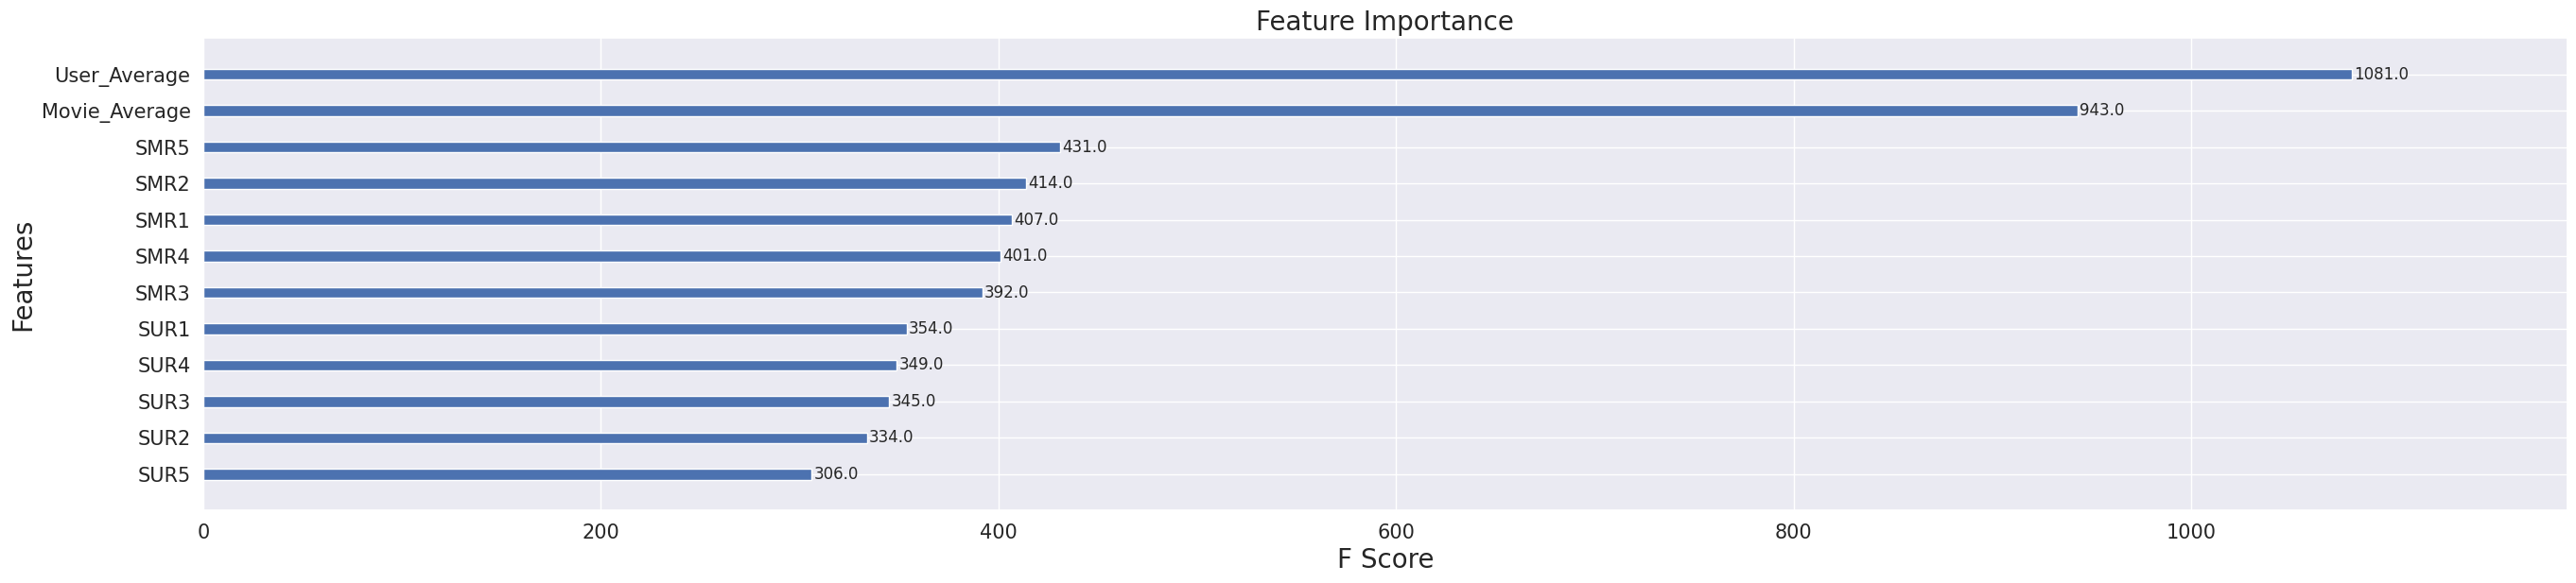

In [ ]:
# Training the Xgboost Regression Model on with the 13 features

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

Observations:

1. "User_Average" by far seems to be the most important feature for rating prediction.
2. "Movie_Average" is the second most important feature to predict the ratings.
3. The top 5 Similar User ratings and top 5 Similar Movie Ratings doesn't seems to be the effective features.

In [ ]:
# Applying BaselineOnly from the surprise library to predict the ratings

bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}
algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly", error_table)

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8121630236924879
MAPE = 26.553605134866494
--------------------------------------------------
TEST DATA
RMSE = 0.9657912792036535
MAPE = 36.443940731076175
--------------------------------------------------
Time Taken = 0:00:00.795623


In [ ]:
# Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

train_regression_data["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
test_regression_data["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]

In [ ]:
train_regression_data.head()
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,285,1938,3.53,3.53,3.21791,4.00,3.00,4.00,2.00,5.00,3.53,3.53,3.53,3.53,3.53,4.0,3.352742
1,425,2624,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0,3.525818
2,425,2952,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.5,3.525818
3,480,9828,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.0,3.525818
4,735,6698,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0,3.525818


--------------------------------------------------
TRAIN DATA
RMSE : 0.6832064208080535
MAPE : 20.841329048242446
--------------------------------------------------
TEST DATA
RMSE : 0.9705999197531137
MAPE : 36.50339245847849
--------------------------------------------------
Time Taken :  0:00:03.705115


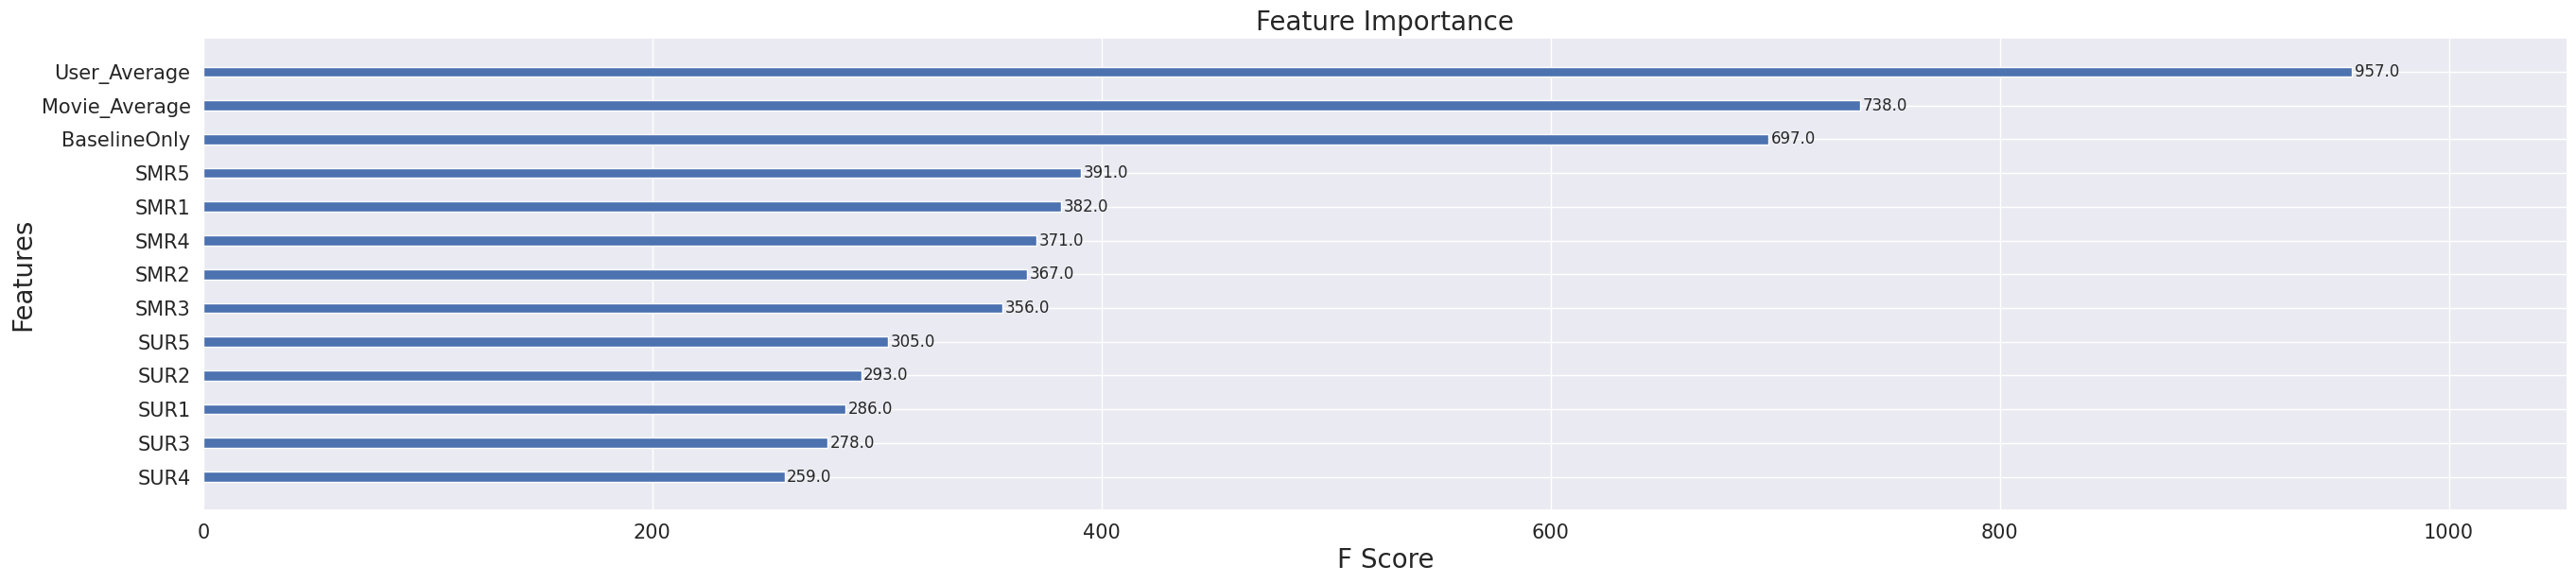

In [ ]:
# Fitting the Xgboost again with new BaselineOnly feature

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

In [ ]:
# Finding the suitable parameter for Surprise KNN-Baseline with User-User Similarity
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [ ]:
# Applying the KNN-Baseline with the searched parameters

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User", error_table)

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3304442611575656
MAPE = 9.854402894337282
--------------------------------------------------
TEST DATA
RMSE = 0.965639914847081
MAPE = 36.42363535396212
--------------------------------------------------
Time Taken = 0:00:38.512558


In [ ]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [ ]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item", error_table)

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.26569020416303857
MAPE = 7.577819261432239
--------------------------------------------------
TEST DATA
RMSE = 0.9656544970329061
MAPE = 36.4276336013529
--------------------------------------------------
Time Taken = 0:00:04.805900


In [ ]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_regression_data["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

test_regression_data["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_regression_data["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [ ]:
train_regression_data.head()
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,285,1938,3.53,3.53,3.21791,4.00,3.00,4.00,2.00,5.00,3.53,3.53,3.53,3.53,3.53,4.0,3.352742,3.337157,3.337157
1,425,2624,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0,3.525818,3.525818,3.525818
2,425,2952,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.5,3.525818,3.525818,3.525818
3,480,9828,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.0,3.525818,3.525818,3.525818
4,735,6698,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0,3.525818,3.525818,3.525818


--------------------------------------------------
TRAIN DATA
RMSE : 0.11468974815317601
MAPE : 2.5942656689241246
--------------------------------------------------
TEST DATA
RMSE : 0.9655258562086445
MAPE : 36.119364377475264
--------------------------------------------------
Time Taken :  0:00:00.814649


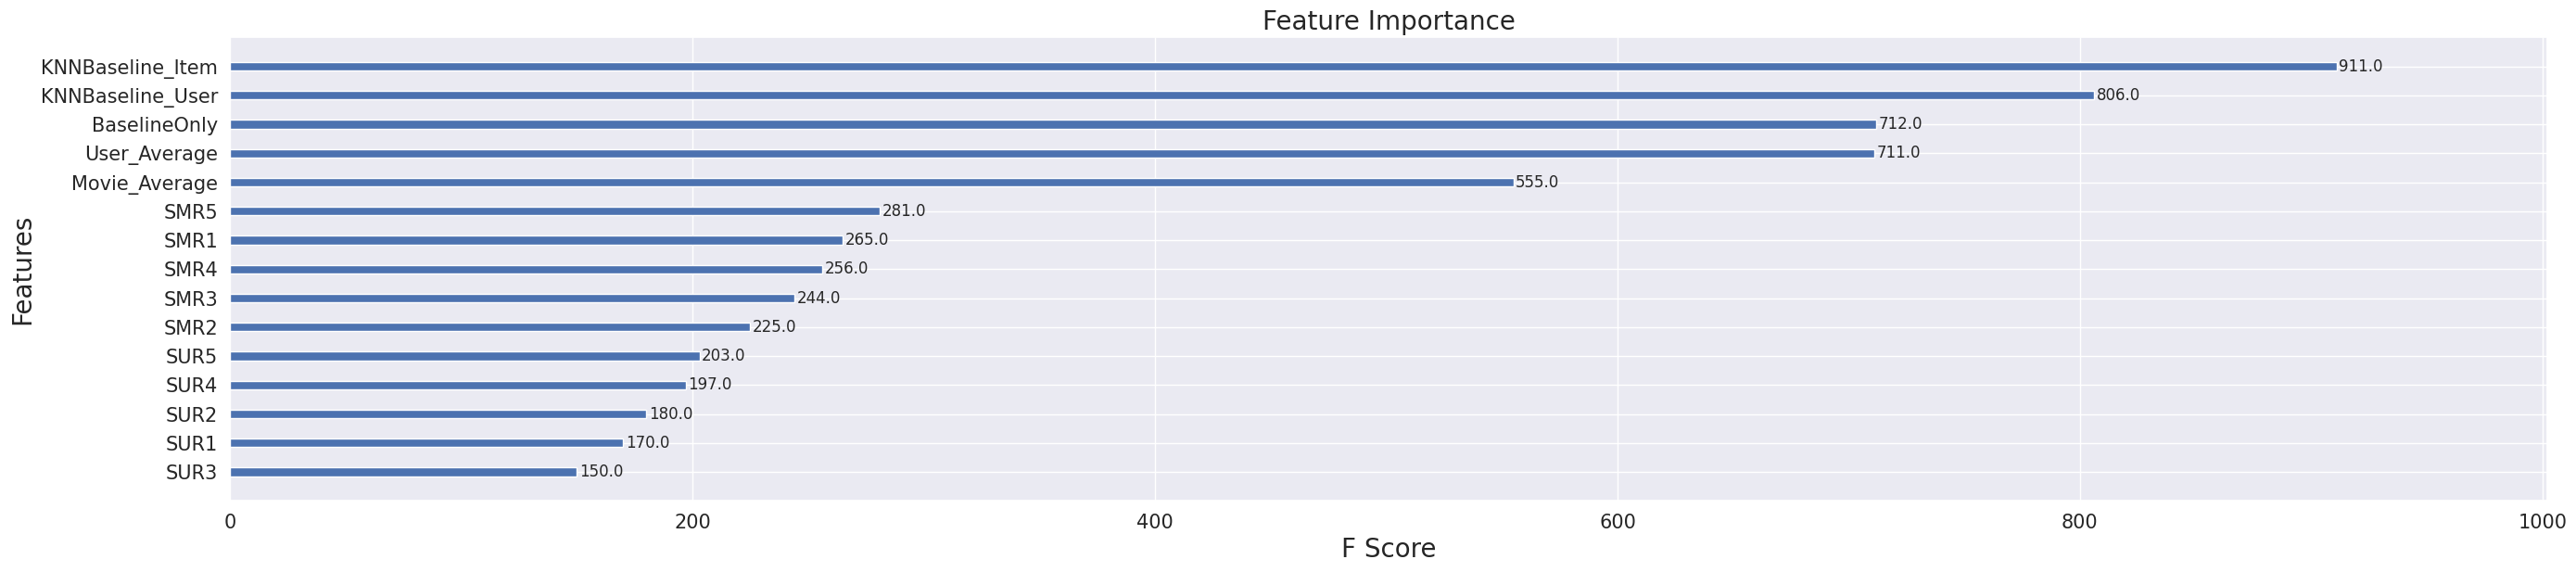

In [ ]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

In [ ]:
# Appling the SlopeOne algorithm from the Surprise library

so = SlopeOne()

train_result, test_result = run_surprise(so, trainset, testset, "SlopeOne", error_table)

model_train_evaluation["SlopeOne"] = train_result
model_test_evaluation["SlopeOne"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE = 0.7444721005098375
MAPE = 23.425615618899222
--------------------------------------------------
TEST DATA
RMSE = 0.9673281969164734
MAPE = 36.56733791750401
--------------------------------------------------
Time Taken = 0:00:01.334434


In [ ]:
# Adding the SlopOne predictions to the train and test datasets

train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]

test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]


In [ ]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8887185662949353
{'n_factors': 5}


In [ ]:
# Applying SVD with best parameters

algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD", error_table)

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8193046513217646
MAPE = 27.09122004108453
--------------------------------------------------
TEST DATA
RMSE = 0.9655999551238782
MAPE = 36.42219713457187
--------------------------------------------------
Time Taken = 0:00:00.547856


In [ ]:
# Matrix Factorization SVDpp with implicit feedback
# Hyper-parameter optimization for SVDpp
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.87821906238295
{'n_factors': 10, 'lr_all': 0.006}


In [ ]:
#Applying SVDpp with best parameters¶

algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp", error_table)

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7490722021232105
MAPE = 24.44402377768878
--------------------------------------------------
TEST DATA
RMSE = 0.9654718228110976
MAPE = 36.44624881375517
--------------------------------------------------
Time Taken = 0:00:06.247859


In [ ]:
# XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

train_regression_data["SVD"] = model_train_evaluation["SVD"]["Prediction"]
train_regression_data["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

test_regression_data["SVD"] = model_test_evaluation["SVD"]["Prediction"]
test_regression_data["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [ ]:
train_regression_data.head()
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVD,SVDpp
0,285,1938,3.53,3.53,3.21791,4.00,3.00,4.00,2.00,5.00,3.53,3.53,3.53,3.53,3.53,4.0,3.352742,3.337157,3.337157,3.525818,3.335047,3.403441
1,425,2624,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0,3.525818,3.525818,3.525818,3.525818,3.525818,3.525818
2,425,2952,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.5,3.525818,3.525818,3.525818,3.525818,3.525818,3.525818
3,480,9828,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.0,3.525818,3.525818,3.525818,3.525818,3.525818,3.525818
4,735,6698,3.53,3.53,3.53000,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,3.53,4.0,3.525818,3.525818,3.525818,3.525818,3.525818,3.525818


--------------------------------------------------
TRAIN DATA
RMSE : 0.10818136256047
MAPE : 2.431683780967224
--------------------------------------------------
TEST DATA
RMSE : 0.9664259085068629
MAPE : 36.25755898432908
--------------------------------------------------
Time Taken :  0:00:00.981686


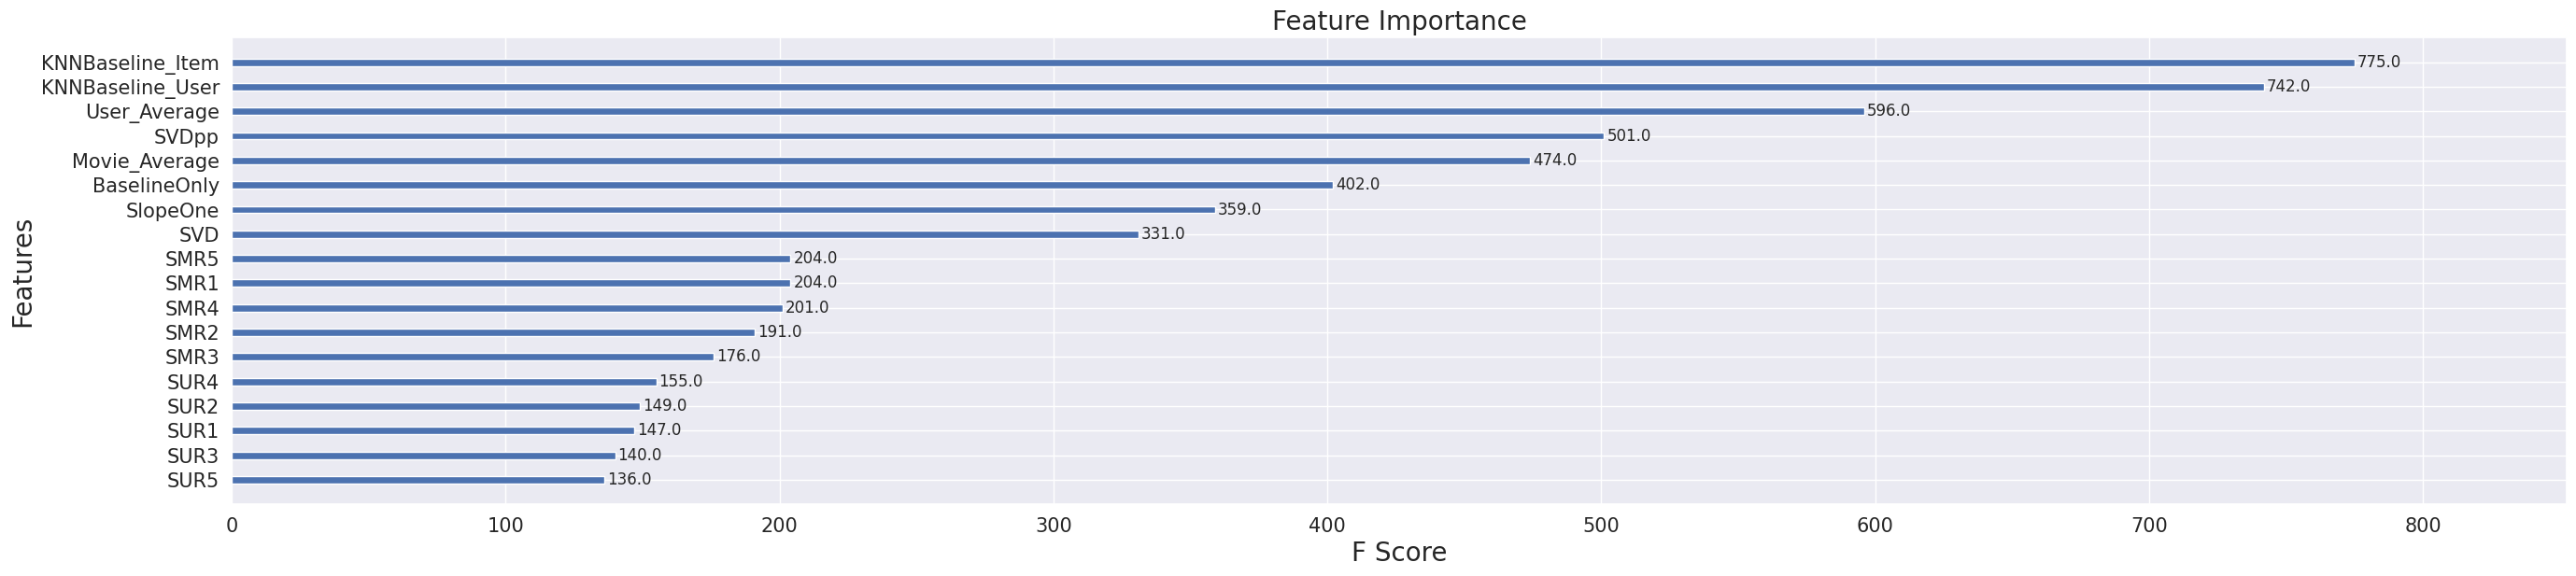

In [ ]:
# Applying Xgboost on the feature set

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE : 0.11999131651846054
MAPE : 2.779022717038433
--------------------------------------------------
TEST DATA
RMSE : 0.9659543934124108
MAPE : 36.30598288366424
--------------------------------------------------
Time Taken :  0:00:00.573277


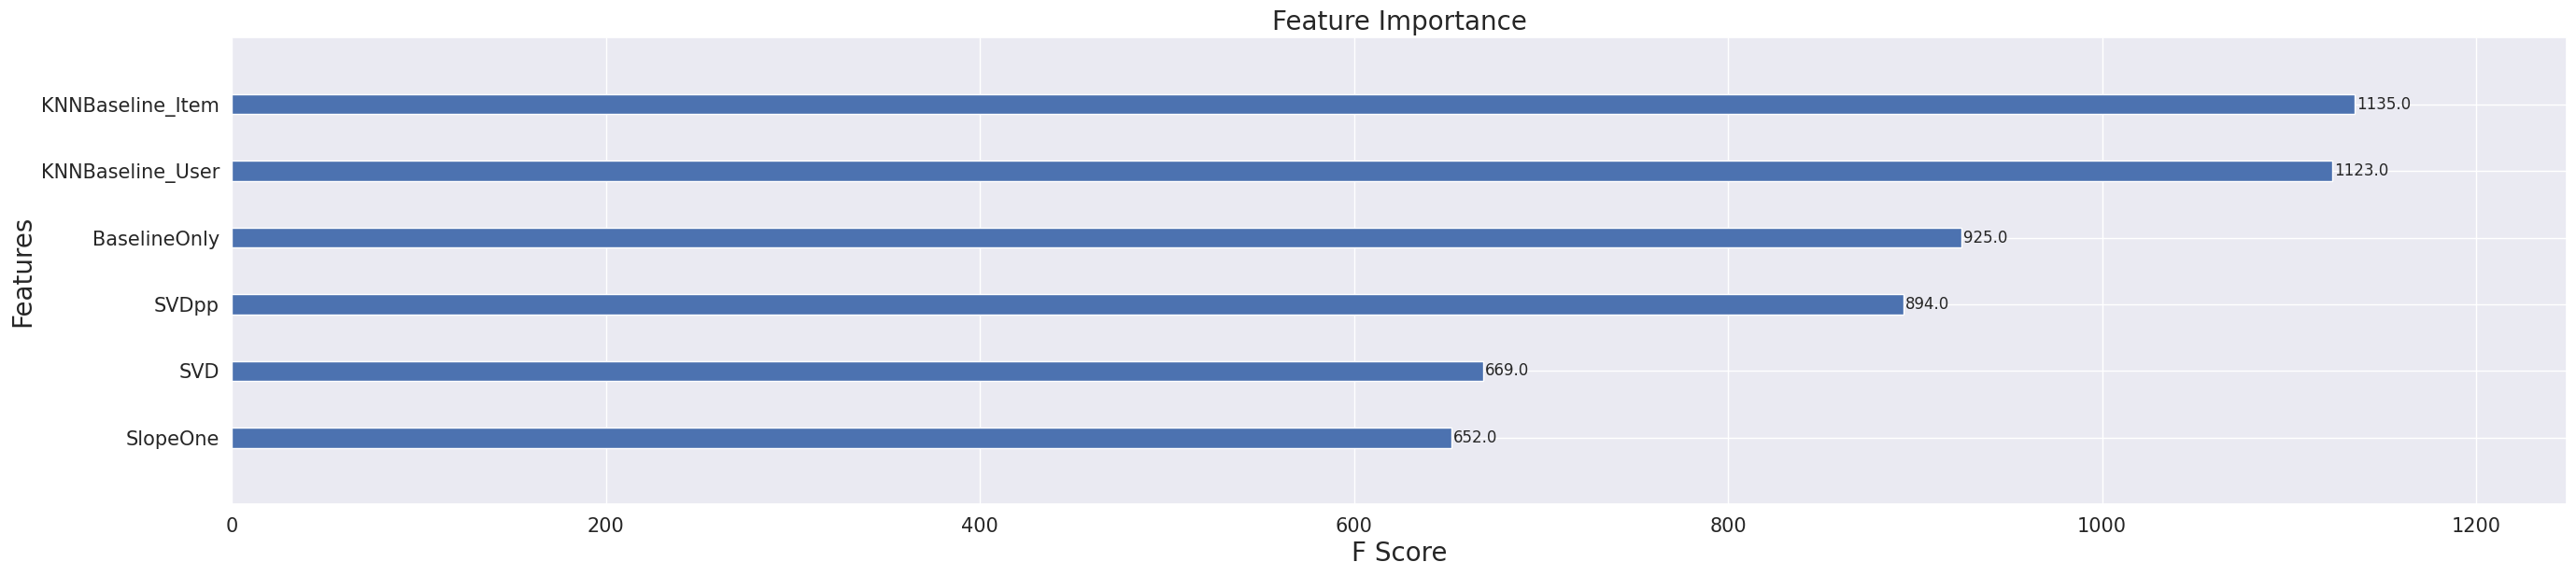

In [ ]:
# Applying Xgboost with Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne

x_train = train_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]
x_test = test_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF_SO")

model_train_evaluation["XGB_KNN_MF_SO"] = train_result
model_test_evaluation["XGB_KNN_MF_SO"] = test_result

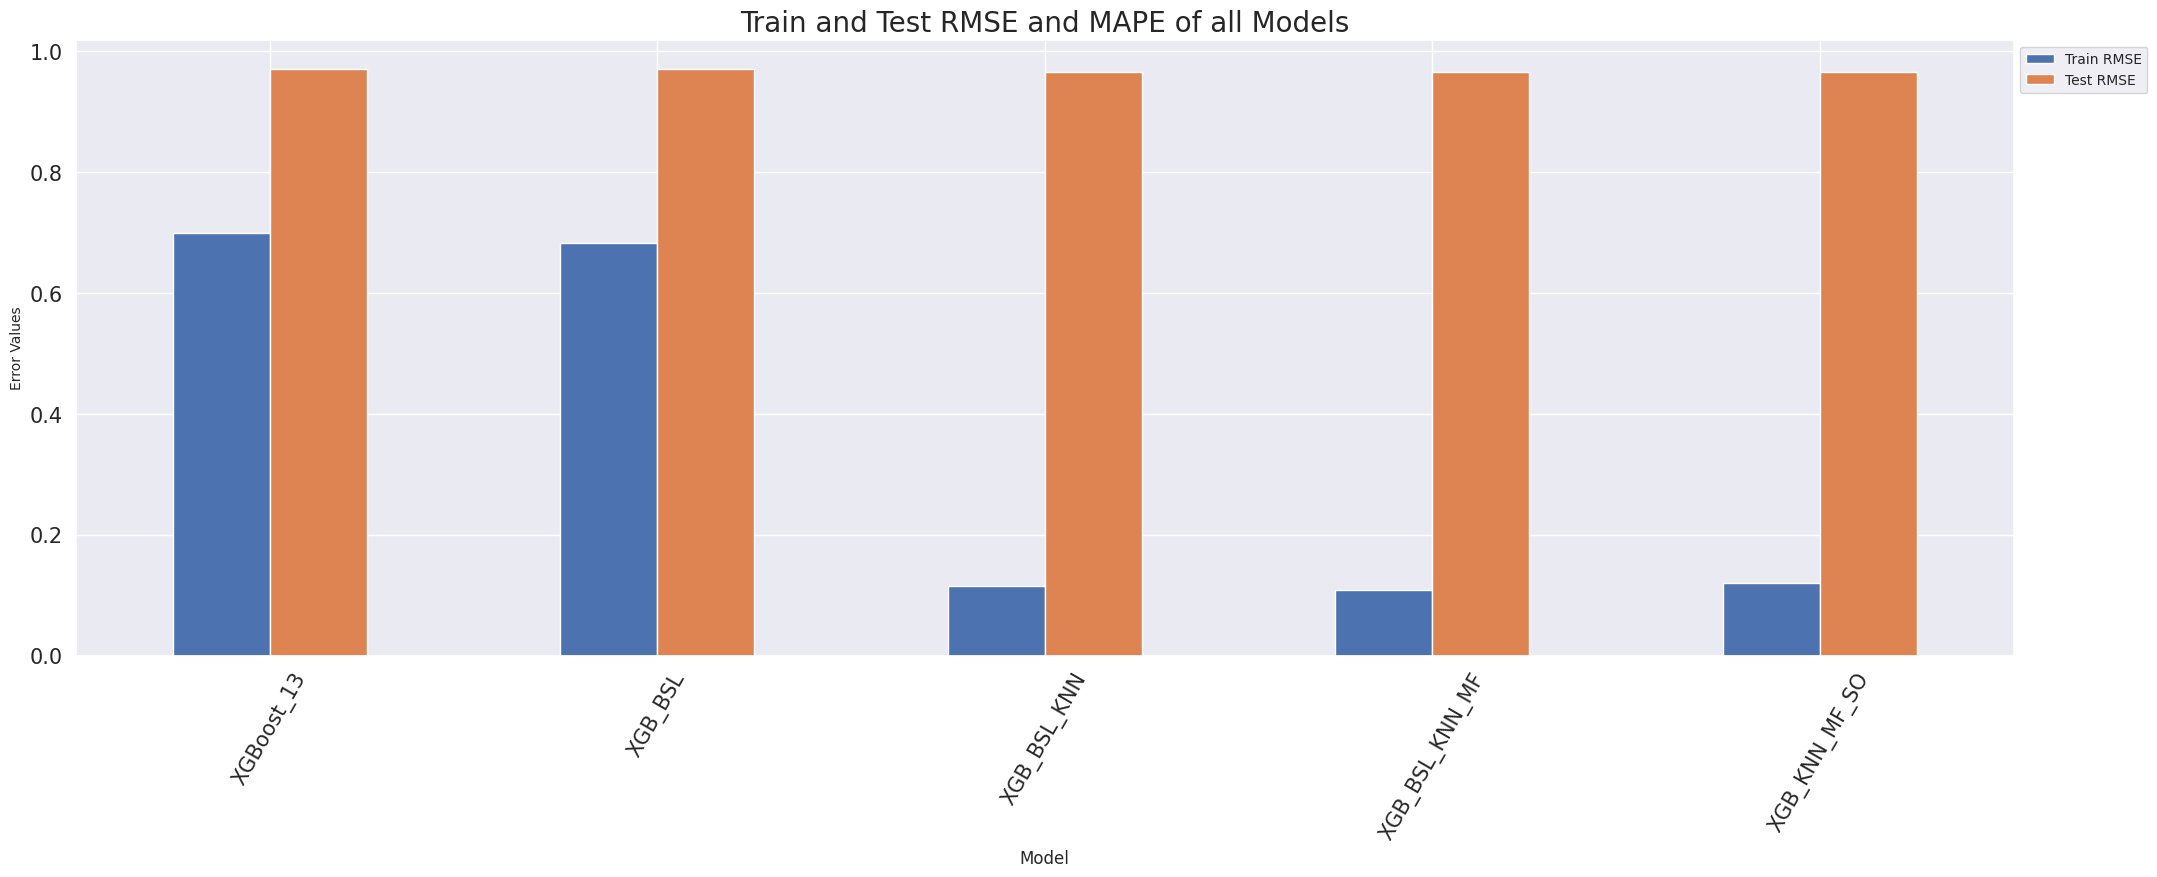

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.699821,0.970901
1,XGB_BSL,0.683206,0.970600
2,XGB_BSL_KNN,0.114690,0.965526
3,XGB_BSL_KNN_MF,0.108181,0.966426
4,XGB_KNN_MF_SO,0.119991,0.965954


In [ ]:
# Visualizing the errors of all the models we tested out
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (25, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 10)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 10)
plt.show()

# Tabular Values of Errors
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

Observations:

All the algorithms seems to do great with the differences remaining very close to each other.

We can see that by using various rating predicting algorithms together and stacking them up, then using final algorithms seems to result in lowest Testing RMSE. Eg: Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne together with Xgboost.

SlopeOne seems to have lowest Testing RMSE out of all other algorithms.

SVDpp and SVD are algorithms showing lower Testing RMSE among rest of the predictors except SlopeOne.

## **Generating Recommendations for Users**

In [ ]:
# Testing the recommendations made by SVDpp Algorithm

from collections import defaultdict

def Get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, mid, true_r, est, _ in predictions:
        top_n[uid].append((mid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Creating instance of svd_pp
svd_pp = SVDpp(n_factors = 10, lr_all = 0.006, verbose=True)
svd_pp.fit(trainset)
predictions = svd_pp.test(testset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


In [ ]:
# Saving the training predictions
train_pred = svd_pp.test(trainset.build_anti_testset())
top_n = Get_top_n(train_pred, n=10)

# Print the recommended items for each user
def Generate_Recommendated_Movies(u_id, n=10):

    recommend = pd.DataFrame(top_n[u_id], columns=["Movie_Id", "Predicted_Rating"])
    recommend = recommend.merge(movies, how="inner", left_on="Movie_Id", right_on="movieId")
    recommend = recommend[["Movie_Id", "title", "genres", "Predicted_Rating"]]

    return recommend[:n]

# Saving the sampled user id list to help generate movies
sampled_user_id = list(top_n.keys())


In [ ]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  45526


,Movie_Id,title,genres,Predicted_Rating
0,662,"World of Apu, The (Apur Sansar) (1959)",Drama,4.588290
1,6808,"Unvanquished, The (Aparajito) (1957)",Drama,4.345762
2,934,"Thin Man, The (1934)",Comedy|Crime,4.321358
3,1185,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,4.284284
4,5873,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy,4.283674
5,576,"Celluloid Closet, The (1995)",Documentary,4.268887
6,6668,Judgment at Nuremberg (1961),Drama,4.265553
7,9576,Hotel Rwanda (2004),Drama|War,4.264012
8,2835,Children of Paradise (Les enfants du paradis) ...,Drama|Romance,4.261729
9,11355,"Pan's Labyrinth (Laberinto del fauno, El) (2006)",Drama|Fantasy|Thriller,4.254068


# **Conclusion**

In this project, we explored the significance of recommendation systems, the various types of recommender systems, and how matrix factorization can be used to improve them.

We then developed a movie recommendation system that incorporates user-user similarity, movie-movie similarity, global averages, and matrix factorization. These concepts can be applied to any user-item interaction systems.

We focused on generating recommendations using similarity matrices and Collaborative Filtering techniques.

We aimed to predict movie ratings based on users' past rating behaviors and evaluated the accuracy using RMSE and MAPE error metrics.

There is certainly a lot of potential for improvement by experimenting with different techniques and exploring advanced ML/DL algorithms.